# Make slurm files required to produce SXDS joint VISTA-HSC data product.

In this notebook we will make all the slurm files required to run the whole VISTA-VIDEO HSC-DUD joint photometry pipeline.

We need to find all the patches in the HSC imaging and produce a slurm pipeline file for every patch or group of patches.

This will be a maximum of around 4 tracts * 91 patches per tract = 364 patches

We will also need to set up the data directories including linking relevant reference catalogues and copying the required HSC data products which are already processed.

NOTE: When running the array jobs I am using wildcards to map the index to a given shell script. This is dangerous if you have multiple versions of the slurm scripts as multiple files might have the id.

The processing happens in broadly three stages determined by the inputs and outputs of jobs which dictate parellelisation.

1. processCcd: inputs/outputs = VISTA images/ calexp ccd exposures. One file per VISTA fits image with 16 exposures/stacks.

2. makeCoadd*: inputs/outputs = calexp ccd exposures/coadd patches. One file per patch which runs every night covering a given patch.

3. detect etc: inputs/outputs = coadd patches/source catalogues on every patch. One file per patch.

UPDATE 20210114: Previoulsy we made one shell and slurm script for every image/patch. We now use a json dictionary of job details so we can submit array jobs more easily.


In [1]:
from astropy.table import Table, Column
import numpy as np
import glob
import os
import json
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'



#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

#Following taken from dmu1/2_Survey_comparisons.ipynb test choice
coord = SpherePoint(35.429025*degrees,-4.90853*degrees)
config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
#and copied for obs_vista
#https://github.com/lsst-uk/obs_vista/blob/master/config/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 # Overlap between tracts (degrees)
config.pixelScale = 0.168
sm = RingsSkyMap(config)
sm.findTract(coord)

TractInfo(id=8524, ctrCoord=[0.8087076683756161, 0.5811684769959703, -0.09074749834931431])

In [2]:
HSC_LOC = '../../dmu0/dmu0_HSC/data'
#WORK_DIR = '/home/ir-shir1/lsst-ir-fusion/dmu4/dmu4_SXDS'
#WORK_DIR = os. getcwd()
WORK_DIR = '/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu4/dmu4_SXDS'
MAKE_INDIVIDUAL_SLURM=False

In [3]:
!mkdir slurm

mkdir: slurm: File exists


In [4]:
video_ims = Table.read('../../dmu1/data/video_images_overview_20210322.csv')
hsc_ims = Table.read('../../dmu1/data/hsc_images_overview_20210315.csv')

In [5]:
tile_to_patch = Table.read('../../dmu1/data/video_tiles_tracts_patches_overview_20200820.csv')

In [6]:
len(video_ims)

243377

## 1 Find all the relevant HSC SXDS patches and corresponding VIDEO images.

The first stage is parallesised by ccd. We will create one job for every stack image (16 CCD exposures). These are small enough to run in a 24hr job.

### 1.1 Get the HSC DUD files in SXDS

In [7]:
sxds_tracts = [8282,8283,8284,8523,8524,8525,8765,8766,8767] #manually got these from HSC DR2 pages
hsc_bands = ['G', 'R', 'I', 'Z', 'Y']
vista_bands = ['Y', 'J', 'H', 'Ks']

In [8]:
hsc_ims['tract'] = [f.split('/')[16] for f in hsc_ims['file']]
hsc_ims['patch'] = [f.split('/')[17] for f in hsc_ims['file']]
hsc_ims['depth'] = [f.split('/')[13] for f in hsc_ims['file']]

In [9]:
in_sxds = hsc_ims['depth'] == 'pdr2_dud' 
in_sxds &= np.isin([int(t) for t in hsc_ims['tract'] ],  sxds_tracts)

In [10]:
np.sum(in_sxds)

1685

In [11]:
hsc_ims['band'] = [f.split('-')[-3] for f in hsc_ims['file']]

In [12]:
hsc_ims[in_sxds][:5]

file,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,size,hash,tract,patch,depth,band
str270,float64,float64,float64,float64,float64,float64,float64,float64,int64,str32,str5,str3,str9,str1
"/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_HSC/data/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-Z/8284/8,8/calexp-HSC-Z-8284-8,8.fits",36.69217386800095,36.69242904434045,36.499815804104315,36.50014621931387,-6.045187123231619,-5.853898675862478,-6.044923976099838,-5.853643936797239,16439040,5ec6eed35b1322d45879648322437cdb,8284,"8,8",pdr2_dud,Z
"/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_HSC/data/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-Z/8282/0,8/calexp-HSC-Z-8282-0,8.fits",35.201429009173566,35.201098593964026,35.00907094527695,35.00881576893745,-6.044923976099834,-5.853643936797223,-6.045187123231627,-5.8538986758624825,7295040,6ff693134146bf0d31919787ab7dbe84,8282,"0,8",pdr2_dud,Z
"/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_HSC/data/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-Z/8523/5,2/calexp-HSC-Z-8523-5,2.fits",34.12577528697288,34.12580307352058,33.92881788924288,33.92890709667817,-5.677927451213364,-5.481936200112909,-5.677863968623236,-5.481874919760293,79286400,1c544c915eb62182dfdf67f7683b2fa5,8523,"5,2",pdr2_dud,Z
"/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_HSC/data/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-Z/8523/4,6/calexp-HSC-Z-8523-4,6.fits",34.313238893944245,34.313208255366284,34.11651317217135,34.11654381074931,-4.931273125246284,-4.735281926575256,-4.931273125246284,-4.735281926575256,195710400,eeb1156aabda8ca3c8916aa29b9a65f6,8523,"4,6",pdr2_dud,Z
"/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu0/dmu0_HSC/data/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-Z/8523/1,5/calexp-HSC-Z-8523-1,5.fits",34.87547979966262,34.87527398811705,34.678714630409196,34.678570114693514,-5.1176066095010935,-4.921621911561685,-5.117778157765401,-4.921786853432868,200491200,c5d5409f44a6ece152715849f2cf2747,8523,"1,5",pdr2_dud,Z


In [13]:
full_patch_dict = {}
band_dict = { hsc_bands[i]: {} for i in range(len(hsc_bands))}
for tract in sxds_tracts:
    full_patch_dict[tract] = [
        s for s in np.unique(np.array(hsc_ims[in_sxds & (hsc_ims['tract'] == str(tract))]['patch']))
    ]
    for band in hsc_bands:
        band_dict[band][tract] = [
            s for s in np.unique(np.array(hsc_ims[
                in_sxds 
                & (hsc_ims['tract'] == str(tract))
                & (hsc_ims['band'] == band)
            ]['patch']))
        ]

In [14]:
json.dumps(full_patch_dict, separators=(',', ':')) 


'{"8282":["0,8"],"8283":["0,8","1,7","1,8","2,7","2,8","3,7","3,8","4,7","4,8","5,7","5,8","6,7","6,8","7,7","7,8","8,8"],"8284":["8,8"],"8523":["0,1","0,2","0,3","0,4","0,5","0,6","0,7","0,8","1,1","1,2","1,3","1,4","1,5","1,6","1,7","1,8","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","3,1","3,2","3,3","3,4","3,5","3,6","3,7","3,8","4,1","4,2","4,3","4,4","4,5","4,6","4,7","4,8","5,2","5,3","5,4","5,5","5,6","5,7","5,8","6,3","6,4","6,5","6,6","6,7","6,8","7,3","7,4","7,5","7,6","7,7","7,8"],"8524":["0,0","0,1","0,2","0,3","0,4","0,5","0,6","0,7","0,8","1,0","1,1","1,2","1,3","1,4","1,5","1,6","1,7","1,8","2,0","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","3,0","3,1","3,2","3,3","3,4","3,5","3,6","3,7","3,8","4,0","4,1","4,2","4,3","4,4","4,5","4,6","4,7","4,8","5,0","5,1","5,2","5,3","5,4","5,5","5,6","5,7","5,8","6,0","6,1","6,2","6,3","6,4","6,5","6,6","6,7","6,8","7,0","7,1","7,2","7,3","7,4","7,5","7,6","7,7","7,8","8,1","8,2","8,3","8,4","8,5","8,6","8,7","8,8"],"8525":["1,

In [15]:
#with open('full_patch_dict.json', 'w') as outfile:
#    json.dump(full_patch_dict, outfile, separators=(',', ':'))

In [16]:
!mkdir figs

mkdir: figs: File exists


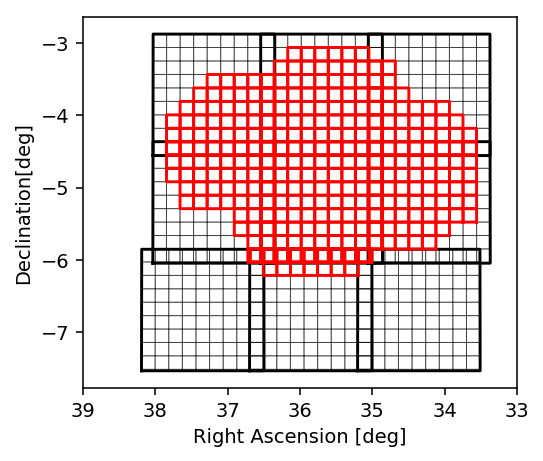

In [17]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
for tract in sxds_tracts:
    vertices = sm.generateTract(tract).getVertexList()
    ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
    dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
    ax.plot(ra, dec, c = 'k')
    for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
        #print(p[0], p[1])
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.5)

#Plot patches on a band
band = 'all'
if band != 'all':
    d = band_dict[band]
else:
    d = full_patch_dict
for tract in d:
    for patch in d[tract]:
        #print(p[0], p[1])
        p = [int(i) for i in patch.split(',')]
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'r')
    
ax.axis('scaled')
ax.set_xlim([39, 33])
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination[deg]')
fig.savefig('./figs/sxds_HSC-{}_patches.pdf'.format(band), overwrite=True)
fig.savefig('./figs/sxds_HSC-{}_patches.png'.format(band), overwrite=True)

In [18]:
#There were some missing patches in tract 8524 in R that we need to download
#Here we check they are now in place.
HSC_R_missing_patches = []
for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
    if "{},{}".format(p[0], p[1]) not in band_dict['R'][8524]:
        #print("{},{}".format(p[0], p[1]))
        HSC_R_missing_patches.append([int(p[0]), int(p[1])])
HSC_R_missing_patches, len(HSC_R_missing_patches)

([[8, 0]], 1)

In [19]:
#sxds_tracts_patches = {sxds_tracts}
#for t in sxds_tracts_patches:

### 1.2 Find VIDEO images containing those patches

To begin we simply find all tiles which contain the centres of any of those patches

In [20]:
video_ims.add_column(Column(
    data= [t.split('/')[-2] for t in video_ims['file']],
    name='date'))

In [21]:
video_ims.sort('date')

In [22]:
def fileToType(filename):
    filetype = ''
    types = {
        'tile':'_tl.fit',
        'stack':'_st.fit',
    }
    for k,v in types.items():
        #print(k,v)
        if filename.endswith(v):
            filetype = k
  
    return filetype
video_ims['type'] = [fileToType(f) for f in video_ims['file']]

In [23]:
def fileToNumObs(filename):
    "Parse the file name to an obsNum"
    obsNum = filename.split('_')[1].strip('_st_tl_conf.fit')
    return obsNum
video_ims['numObs'] = [fileToNumObs(f) for f in video_ims['file']]

In [24]:
def stackToPatchList(files, file, tile_to_patch):
    """Take a stack file and find the corresponding tile and patch list"""
    tiles_on_date = files[
        (files['date'] == file['date'])
        &(files['type'] == 'tile')
    ]
    numObs = file['numObs']
    #get the largest tile numObs below the stack/exposure numObs for the given date
    try:
        print(file['date'],numObs,tiles_on_date['numObs'])
        tileNumObs = np.max([int(i) if (int(i) <= int(numObs)) else -99 for i in tiles_on_date['numObs']])
        print(tileNumObs)
        tile = '/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/{}/v{}_{}_st_tl.fit'.format(
            file['date'],
            file['date'],
            str(tileNumObs).zfill(5) # turn e.g. int 56 to '00056'
        )
        patches = tile_to_patch[tile_to_patch['file'] == tile]['tract_patch_json'][0]
    except:
        patches = ''
    return patches
#video_ims['tract_patch_json'] = [stackToPatchList(video_ims, i, tile_to_patch) for i in video_ims]
#stackToPatchList(video_ims, video_ims[video_ims['tract_patch_json']==''][0], tile_to_patch)

In [25]:
video_ims[:5]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,visit,exptime,hash,MAGZPT,MAGZRR,SEEING,date,type,numObs
str98,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,int64,int64,int64,float64,float64,float64,str8,str5,str5
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00384_st_conf.fit,36.666425,-4.82327,37.18232571156968,37.184068164840504,36.97585303603417,36.977002020699146,-4.171887667334206,-4.378419397652754,-4.170830463948671,-4.377742323421129,H,25015680,12046,10,--,nan,nan,nan,20091103,,00384
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00337.fit,36.672471,-4.63258,37.18029053685955,37.181681594093405,36.98782445125926,36.98872485979129,-3.9884375120380535,-4.179907928968988,-3.987401936187142,-4.179184511608509,H,106473600,11999,60,--,nan,nan,nan,20091103,,00337
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00319_st_tl_conf.fit,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,0,0,0,--,nan,nan,nan,20091103,,00319
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00358.fit,36.488679,-4.81575,36.99678345840081,36.9981300773367,36.80427371184416,36.805127419689725,-4.171732844054423,-4.363203579266777,-4.1706514694569226,-4.362434258248707,H,104690880,12020,60,--,nan,nan,nan,20091103,,00358
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00367.fit,36.481129,-4.63406,36.98912995651607,36.9904674970784,36.79666379317547,36.797510578766826,-3.990063823329973,-4.181534619671177,-3.988974713687807,-4.180757532137754,H,104114880,12029,60,--,nan,nan,nan,20091103,,00367


In [26]:
#TODO make more sophisticated overlap tester. Use patches?
#make list of patches for every tile?
near_sxds = video_ims['type'] == 'stack'
near_sxds &= video_ims['ra'] > 32 #generous bounding box for simplicity 
near_sxds &= video_ims['ra'] < 39
near_sxds &= video_ims['dec'] > -8
near_sxds &= video_ims['dec'] < -1
#Just run Ks for now
#near_sxds &= video_ims['filter'] == 'Ks'

In [27]:
np.sum(near_sxds)

5263

In [28]:
tiles_near_sxds = video_ims['type'] == 'tile'
tiles_near_sxds &= video_ims['ra'] > 32 #generous bounding box for simplicity 
tiles_near_sxds &= video_ims['ra'] < 39
tiles_near_sxds &= video_ims['dec'] > -8
tiles_near_sxds &= video_ims['dec'] < -1

In [29]:
np.sum(tiles_near_sxds)

863

In [30]:
tile_to_patch[:1]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,hash,type,tract_patch_json
str93,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,str32,str4,str631
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20140924/v20140924_00444_st_tl.fit,35.429542,-4.72215,36.12993723683939,36.13433423332165,34.912894878395214,34.91462725348546,-4.072782101046067,-5.559458172880838,-4.07547203760631,-5.562153562881393,Y,148561920,ccef567359a9d3f1cef197b5b5dad958,tile,"{""8766"":[[2,0],[2,1],[2,2],[3,0],[3,1],[3,2],[4,0],[4,1],[4,2],[5,0],[5,1],[5,2],[6,0],[6,1],[6,2],[7,0],[7,1],[7,2],[8,0],[8,1],[8,2]],""8524"":[[2,2],[2,3],[2,4],[2,5],[2,6],[2,7],[2,8],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8],[4,2],[4,3],[4,4],[4,5],[4,6],[4,7],[4,8],[5,2],[5,3],[5,4],[5,5],[5,6],[5,7],[5,8],[6,2],[6,3],[6,4],[6,5],[6,6],[6,7],[6,8],[7,2],[7,3],[7,4],[7,5],[7,6],[7,7],[7,8],[8,2],[8,3],[8,4],[8,5],[8,6],[8,7],[8,8]],""8765"":[[0,0],[0,1],[0,2]],""8523"":[[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8]]}"


In [31]:
video_ims[near_sxds][:5]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,visit,exptime,hash,MAGZPT,MAGZRR,SEEING,date,type,numObs
str98,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,int64,int64,int64,float64,float64,float64,str8,str5,str5
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00377_st.fit,36.666387,-4.64011,37.181911349666635,37.183711783195584,36.97552002531141,36.97672988686314,-3.9882754312027484,-4.194658362408524,-3.987245352372556,-4.194007866262817,H,89078400,12039,10,--,23.881,0.016,2.306127,20091103,stack,00377
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00354_st.fit,36.484087,-4.82318,36.996787081011924,36.998436443161054,36.79310205460922,36.794170839602,-4.171884269479345,-4.376103522846783,-4.170722799127453,-4.3753101690312555,H,86860800,12016,10,--,23.867,0.01,2.228134,20091103,stack,00354
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00333_st.fit,36.667887,-4.64001,37.180057354163154,37.181794976732,36.97657410259618,36.97773353926015,-3.9878357167901357,-4.192071768125217,-3.9868068960692162,-4.191411222306248,H,86955840,11995,10,--,23.869,0.024,2.130813,20091103,stack,00333
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00384_st.fit,36.666425,-4.82327,37.182309328591025,37.184072665241715,36.975848468202194,36.97701845296873,-4.171882107051631,-4.3784252190389035,-4.170829644944778,-4.3777528775200905,H,90043200,12046,10,--,23.879,0.017,2.549619,20091103,stack,00384
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20091103/v20091103_00326_st.fit,36.576012,-4.64,37.08823163355052,37.08995555636475,36.88482927617349,36.8859752930554,-3.987866954738439,-4.192091543332042,-3.9868182149356515,-4.191410879371404,H,86803200,11988,10,--,23.872,0.02,2.018134,20091103,stack,00326


In [32]:
#video_ims[near_sxds].write('./data/sxds_tiles.csv')

In [33]:
#For simplicity lets ingest all the images (They are only links and this stage is fast)
#!mkdir data
#!mkdir slurm
#!ingestImages.py data /home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/*/*_st.fit #Stacks
#for date in date_list:
#    #!ingestImages.py data /path/to/vista/{date}/*[0-9].fit #Exposures
#    !ingestImages.py data /path/to/vista/{date}/*_st.fit #Stacks

In [34]:
#date_list = ['20121122', '20171027'] #test dates
date_list = np.unique(video_ims['date'][near_sxds])

In [35]:
#Number of stack files in total tile date list
np.sum(np.isin(video_ims['date'][video_ims['type'] == 'stack'], date_list))

8095

In [36]:
date_list = [date[0:4]+'-'+date[4:6]+'-'+date[6:9] for date in date_list]

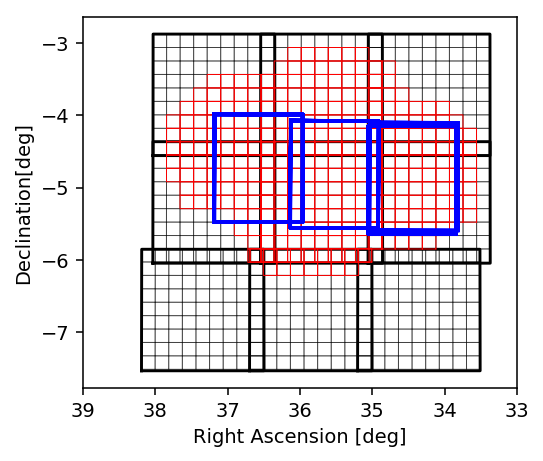

In [37]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
for tract in sxds_tracts:
    vertices = sm.generateTract(tract).getVertexList()
    ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
    dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
    ax.plot(ra, dec, c = 'k')
    for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
        #print(p[0], p[1])
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.5)

#Plot patches on a band
band = 'all'
if band != 'all':
    d = band_dict[band]
else:
    d = full_patch_dict
for tract in d:
    for patch in d[tract]:
        #print(p[0], p[1])
        p = [int(i) for i in patch.split(',')]
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'r', alpha=1.0, linewidth=0.5)
        
v_band ='all'
for t in video_ims[
    (video_ims['type'] == 'tile') 
    #& (video_ims['filter'] == v_band) 
    & tiles_near_sxds]:

    ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
    dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]
    
    ax.plot(ra,dec, c = 'b')
    
ax.axis('scaled')
ax.set_xlim([39, 33])
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination[deg]')
fig.savefig('./figs/sxds_HSC-{}_patches_VISTA-{}_tiles.pdf'.format(band,v_band), overwrite=True)
fig.savefig('./figs/sxds_HSC-{}_patches_VISTA-{}_tiles.png'.format(band,v_band), overwrite=True)

In [38]:
tiles_in_sxds = tile_to_patch['ra'] < 39
tiles_in_sxds &= tile_to_patch['ra'] > 33
tiles_in_sxds = tile_to_patch['dec'] < -2
tiles_in_sxds = tile_to_patch['dec'] >-8
tile_to_patch[tiles_in_sxds][:1]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,hash,type,tract_patch_json
str93,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,str32,str4,str631
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO/20140924/v20140924_00444_st_tl.fit,35.429542,-4.72215,36.12993723683939,36.13433423332165,34.912894878395214,34.91462725348546,-4.072782101046067,-5.559458172880838,-4.07547203760631,-5.562153562881393,Y,148561920,ccef567359a9d3f1cef197b5b5dad958,tile,"{""8766"":[[2,0],[2,1],[2,2],[3,0],[3,1],[3,2],[4,0],[4,1],[4,2],[5,0],[5,1],[5,2],[6,0],[6,1],[6,2],[7,0],[7,1],[7,2],[8,0],[8,1],[8,2]],""8524"":[[2,2],[2,3],[2,4],[2,5],[2,6],[2,7],[2,8],[3,2],[3,3],[3,4],[3,5],[3,6],[3,7],[3,8],[4,2],[4,3],[4,4],[4,5],[4,6],[4,7],[4,8],[5,2],[5,3],[5,4],[5,5],[5,6],[5,7],[5,8],[6,2],[6,3],[6,4],[6,5],[6,6],[6,7],[6,8],[7,2],[7,3],[7,4],[7,5],[7,6],[7,7],[7,8],[8,2],[8,3],[8,4],[8,5],[8,6],[8,7],[8,8]],""8765"":[[0,0],[0,1],[0,2]],""8523"":[[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8]]}"


In [39]:
patches_in_video = {}
for t in tile_to_patch[tiles_in_sxds]:
    patch_dict = json.loads(t['tract_patch_json'])
    for tract in patch_dict:
        patches_string_set = set([str(d) for d in  patch_dict[tract]])
        try:
            patches_in_video[tract] = patches_in_video[tract].union(patches_string_set)
        except KeyError:
            patches_in_video[tract] = patches_string_set

for tract in patches_in_video:
    patches_in_video[tract] = [
        [int(s.split(',')[0].strip('[')), int(s.split(',')[1].strip(']'))] 
        for s in patches_in_video[tract]
    ]
    
patches_in_video
json.dumps(patches_in_video, separators=(',', ':'))

'{"8766":[[1,1],[1,3],[3,0],[0,1],[5,0],[3,2],[6,0],[5,1],[6,1],[1,2],[0,3],[1,0],[8,2],[0,0],[6,2],[2,1],[8,0],[4,1],[3,3],[7,0],[4,2],[2,0],[8,1],[3,1],[7,1],[2,2],[2,3],[4,0],[5,2],[0,2],[7,2]],"8524":[[4,8],[0,5],[8,5],[2,8],[6,2],[5,5],[3,7],[7,6],[4,2],[1,4],[2,2],[8,3],[7,2],[1,6],[1,3],[0,4],[6,6],[7,8],[3,8],[4,6],[7,4],[0,3],[8,2],[3,6],[2,4],[6,5],[6,8],[0,8],[4,7],[8,6],[6,4],[8,8],[4,3],[7,3],[5,2],[1,5],[5,3],[2,7],[5,6],[2,6],[2,5],[5,4],[6,7],[1,8],[4,5],[1,7],[4,4],[0,7],[5,8],[0,6],[5,7],[3,2],[7,7],[7,5],[6,3],[8,4],[1,2],[3,4],[3,5],[3,3],[8,7],[2,3],[0,2]],"8765":[[3,0],[0,1],[5,0],[6,0],[5,1],[6,1],[1,0],[6,2],[4,1],[4,2],[3,1],[2,2],[4,0],[1,1],[3,2],[1,2],[0,0],[2,1],[2,0],[5,2],[0,2]],"8523":[[4,8],[0,5],[2,8],[6,2],[5,5],[3,7],[4,2],[1,4],[2,2],[1,6],[1,3],[0,4],[6,6],[3,8],[4,6],[0,3],[3,6],[0,8],[2,4],[6,5],[6,8],[4,7],[6,4],[4,3],[5,2],[1,5],[5,3],[2,7],[5,6],[2,6],[2,5],[5,4],[6,7],[1,8],[4,5],[1,7],[4,4],[0,7],[5,8],[0,6],[5,7],[3,2],[1,2],[6,3],[3,4],[3,

In [40]:
with open('patches_in_video.json', 'w') as outfile:
    json.dump(patches_in_video, outfile, separators=(',', ':'))

## Make patch dictionary

Now we run each patch using the job dict which takes the array integer and returns the job details

In [41]:
patch_job_dict = {}
n=0
for tract in patches_in_video:
    for patch in patches_in_video[tract]:
        patch_job_dict[str(n)]=[int(tract), "{},{}".format(patch[0],patch[1]) ]
        n+=1
n

219

In [42]:
json.dumps(patch_job_dict)

'{"0": [8766, "1,1"], "1": [8766, "1,3"], "2": [8766, "3,0"], "3": [8766, "0,1"], "4": [8766, "5,0"], "5": [8766, "3,2"], "6": [8766, "6,0"], "7": [8766, "5,1"], "8": [8766, "6,1"], "9": [8766, "1,2"], "10": [8766, "0,3"], "11": [8766, "1,0"], "12": [8766, "8,2"], "13": [8766, "0,0"], "14": [8766, "6,2"], "15": [8766, "2,1"], "16": [8766, "8,0"], "17": [8766, "4,1"], "18": [8766, "3,3"], "19": [8766, "7,0"], "20": [8766, "4,2"], "21": [8766, "2,0"], "22": [8766, "8,1"], "23": [8766, "3,1"], "24": [8766, "7,1"], "25": [8766, "2,2"], "26": [8766, "2,3"], "27": [8766, "4,0"], "28": [8766, "5,2"], "29": [8766, "0,2"], "30": [8766, "7,2"], "31": [8524, "4,8"], "32": [8524, "0,5"], "33": [8524, "8,5"], "34": [8524, "2,8"], "35": [8524, "6,2"], "36": [8524, "5,5"], "37": [8524, "3,7"], "38": [8524, "7,6"], "39": [8524, "4,2"], "40": [8524, "1,4"], "41": [8524, "2,2"], "42": [8524, "8,3"], "43": [8524, "7,2"], "44": [8524, "1,6"], "45": [8524, "1,3"], "46": [8524, "0,4"], "47": [8524, "6,6"], 

In [43]:
with open('./slurm/patch_job_dict.json', 'w') as outfile:
    json.dump(patch_job_dict, outfile, separators=(',', ':'))

## Plot patches

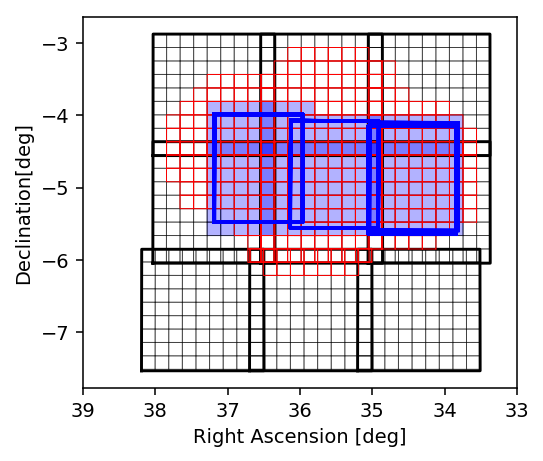

In [44]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
for tract in sxds_tracts:
    vertices = sm.generateTract(tract).getVertexList()
    ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
    dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
    ax.plot(ra, dec, c = 'k')
    for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
        #print(p[0], p[1])
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.5)
        
d = full_patch_dict
for tract in d:
    for patch in d[tract]:
        #print(p[0], p[1])
        p = [int(i) for i in patch.split(',')]
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'r', alpha=1.0, linewidth=0.5)

#Plot patches in video
d = patches_in_video
for tract in d:
   
    for patch in d[tract]:
        #print(p[0], p[1])
        p = patch #[int(i) for i in patch.split(',')]
        t = sm.generateTract(int(tract))
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.fill(ra, dec, c = 'b', alpha=0.3, linewidth=0.5)
        
v_band ='all'
for t in video_ims[
    (video_ims['type'] == 'tile') 
    #& (video_ims['filter'] == v_band) 
    & tiles_near_sxds]:

    ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
    dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]
    
    ax.plot(ra,dec, c = 'b')
    
ax.axis('scaled')
ax.set_xlim([39, 33])
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination[deg]')
fig.savefig('./figs/sxds_VIDEO_patches.pdf', overwrite=True)
fig.savefig('./figs/sxds_VIDEO_patches.png', overwrite=True)

## 2 Make inage dictionary

This stage is parallelised accroding to the raw files ingested. We are going to make one job per date

In [45]:
# n= 0
# for im in video_ims[near_sxds]: #date_list:
#     date = im['date']
#     dateObs = date[0:4]+'-'+date[4:6]+'-'+date[6:9]
#     numObs = im['numObs']
#     _filter = 'VISTA-' +im['filter'] #filter is a reserved word in python
#     job_name = "processCcd_{}_{}_{}".format(dateObs, numObs, n)
#     f_sh = open('./slurm/' + job_name + '.sh', "w+")
#     f_sh.write(sh_template.format(dateObs=dateObs, numObs=numObs, _filter=_filter))
#     f_sh.close()
#     if MAKE_INDIVIDUAL_SLURM:
#         f_slurm = open('./slurm/' + job_name + '.slurm', "w+")
#         f_slurm.write(slurm_template.format(
#             job_name=job_name,
#             hours='1',
#             jobNameBase=WORK_DIR + '/slurm/' + job_name + '.sh',
#             cpus_per_task='1',
#             himem=''
#         ))
#         f_slurm.close()
#     n+=1
# n

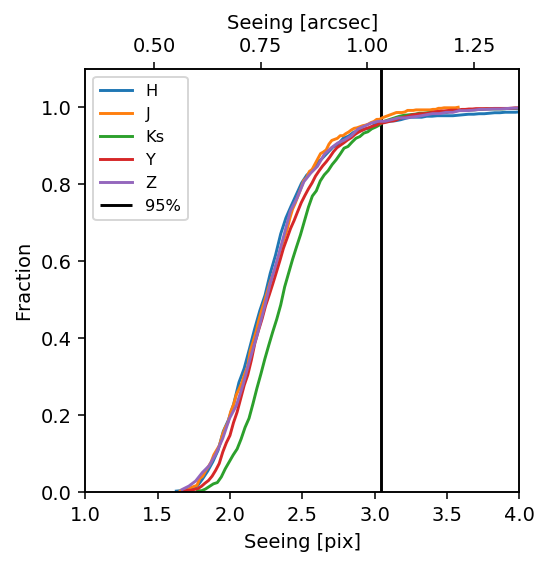

In [196]:
fig = plt.figure(figsize=(4, 4), dpi=140)
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
lims=[1,4]
pixwidth=0.339
#hist=np.histogram(video_ims[near_sxds]['SEEING'],bins=100)
#X=[np.mean([hist[1][n],hist[1][n+1]]) for n in np.arange(len(hist[1])-1)] 
#Y=hist[0]
for band in np.unique(video_ims[~video_ims['filter'].mask]['filter']):

    #print(band)
    m = near_sxds & (video_ims['filter']==band)


    hist=np.histogram(video_ims[m]['SEEING'],bins=100)
    bin_edges=hist[1]
    bin_middles = (bin_edges[1:] + bin_edges[:-1])/2
    cum_sum=np.cumsum(hist[0])/np.sum(hist[0])
    ax1.plot(bin_middles,cum_sum,label=band)

    ax1.set_ylim([0,1.1])
    ax1.set_xlabel(r"Seeing [pix]")
    ax1.set_xlim(lims)
    ax1.set_ylabel('Fraction')
    

seeing_p95=np.nanpercentile(video_ims['SEEING'],95)
ax1.vlines(seeing_p95,0,1.1,label='95%')

ax1.legend(fontsize='small')

new_tick_locations = np.array([0.5,0.75,1,1.25])/pixwidth
def tick_function(X):
    V = X*pixwidth
    return ["%.2f" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Seeing [arcsec]")
fig.savefig('./figs/sxds_seeing_hist.pdf', overwrite=True, bbox_inches='tight')
fig.savefig('./figs/sxds_seeing_hist.png', overwrite=True, bbox_inches='tight')

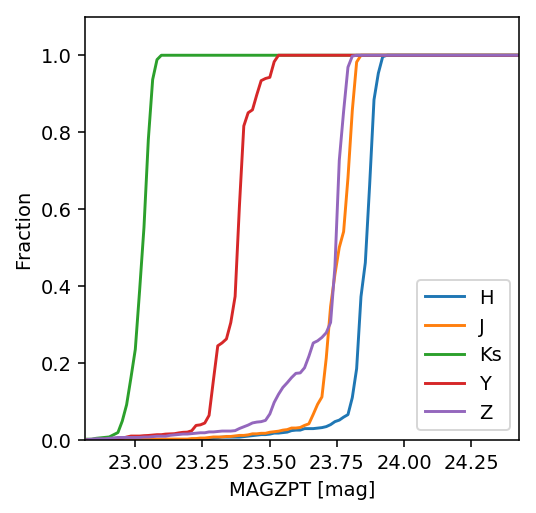

In [204]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
band='Ks'
m = near_sxds & (video_ims['filter']==band)
lims=[
    np.nanpercentile(video_ims['MAGZPT'],1),
    np.nanpercentile(video_ims['MAGZPT'],99.9)+0.5
]

for band in np.unique(video_ims[~video_ims['filter'].mask]['filter']):

    #print(band)
    m = near_sxds & (video_ims['filter']==band)


    hist=np.histogram(video_ims[m]['MAGZPT'],bins=100,range=lims)
    bin_edges=hist[1]
    bin_middles = (bin_edges[1:] + bin_edges[:-1])/2
    cum_sum=np.cumsum(hist[0])/np.sum(hist[0])
    ax.plot(bin_middles,cum_sum,label=band)

    
    ax.set_xlabel(r"Seeing [pix]")
    
    ax.set_ylabel('Fraction')
 
ax.set_ylim([0,1.1])
ax.set_xlim(lims)

ax.set_xlabel(r"MAGZPT [mag]")
#ax.set_xlim(lims)
ax.set_ylabel('Fraction')
ax.legend()
fig.savefig('./figs/sxds_zp_hist.pdf', overwrite=True, bbox_inches='tight')
fig.savefig('./figs/sxds_zp_hist.png', overwrite=True, bbox_inches='tight')

In [160]:
print(
    np.sum(near_sxds),
    np.sum(near_sxds & (video_ims['MAGZPT']<zp_p95)),
    np.sum(near_sxds & (video_ims['MAGZPT']<zp_p95) & (video_ims['SEEING']<seeing_p95)),
)

5263 4990 4729


In [161]:
np.sum(near_sxds & (video_ims['MAGZPT']<zp_p95) & (video_ims['SEEING']<seeing_p95))/np.sum(near_sxds)

0.8985369561086832

In [46]:
BASE='/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEO'

In [47]:
sxds_tracts

[8282, 8283, 8284, 8523, 8524, 8525, 8765, 8766, 8767]

In [48]:
tracts_st = ''
for t in sxds_tracts:
    tracts_st+="{}^".format(t)
tracts_st = tracts_st[:-1]
tracts_st

'8282^8283^8284^8523^8524^8525^8765^8766^8767'

In [49]:
processCcd_job_dict = {}
sxds_ims = video_ims[near_sxds]
for i in np.arange(len(sxds_ims)):
    date=sxds_ims[i]['file'].split('/')[9]
    processCcd_job_dict[str(i)] = [
        '{}-{}-{}'.format(date[0:4],date[4:6],date[6:9]),
        sxds_ims[i]['file'].split('/')[10].split('_')[1],
        'VISTA-{}'.format(sxds_ims[sxds_ims['file']==sxds_ims[i]['file']]['filter'][0]),
        tracts_st,
        BASE+sxds_ims[i]['file'][37:]
    ]

In [50]:
processCcd_job_dict['0']

['2009-11-03',
 '00377',
 'VISTA-H',
 '8282^8283^8284^8523^8524^8525^8765^8766^8767',
 '/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VIDEOa/private/VISTA/VIDEO/20091103/v20091103_00377_st.fit']

In [51]:
with open('./slurm/processCcd_job_dict.json', 'w') as outfile:
    json.dump(processCcd_job_dict, outfile, separators=(',', ':'))

In [52]:
len(processCcd_job_dict)

5263